## Install Python dependencies

In [1]:
!pip install --upgrade pip
!pip install onnx onnxruntime tf2onnx

Import the dependencies for the model training code:

In [2]:
import numpy as np
import pandas as pd
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tf2onnx
import onnx
import pickle
from pathlib import Path

2025-08-06 00:27:09.891707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754440029.915348    9240 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754440029.922595    9240 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-06 00:27:09.947040: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


The output might show TensorFlow messages, such as a "Could not find TensorRT" warning. You can ignore these messages.


## Load the CSV data

The CSV data that you use to train the model contains the following fields:

* **distancefromhome** - The distance from home where the transaction happened.
* **distancefromlast_transaction** - The distance from the last transaction that happened.
* **ratiotomedianpurchaseprice** - The ratio of purchased price compared to median purchase price.
* **repeat_retailer** - If it's from a retailer that already has been purchased from before.
* **used_chip** - If the credit card chip was used.
* **usedpinnumber** - If the PIN number was used.
* **online_order** - If it was an online order.
* **fraud** - If the transaction is fraudulent.

In [3]:
# Set the input (X) and output (Y) data. 
# The only output data is whether it's fraudulent. All other fields are inputs to the model.

feature_indexes = [
    1,  # distance_from_last_transaction
    2,  # ratio_to_median_purchase_price
    4,  # used_chip
    5,  # used_pin_number
    6,  # online_order
]

label_indexes = [
    7  # fraud
]

df = pd.read_csv('data/train.csv')
X_train = df.iloc[:, feature_indexes].values
y_train = df.iloc[:, label_indexes].values

df = pd.read_csv('data/validate.csv')
X_val = df.iloc[:, feature_indexes].values
y_val = df.iloc[:, label_indexes].values

df = pd.read_csv('data/test.csv')
X_test = df.iloc[:, feature_indexes].values
y_test = df.iloc[:, label_indexes].values


# Scale the data to remove mean and have unit variance. The data will be between -1 and 1, which makes it a lot easier for the model to learn than random (and potentially large) values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global distribution of variables (which is influenced by the test set) into the training set.

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Path("artifact").mkdir(parents=True, exist_ok=True)
with open("artifact/test_data.pkl", "wb") as handle:
    pickle.dump((X_test, y_test), handle)
with open("artifact/scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)

# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones), set a class weight to weight the few fraudulent transactions higher than the many non-fraud transactions.
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

## Build the model

The model is a simple, fully-connected, deep neural network, containing three hidden layers and one output layer.

In [4]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=len(feature_indexes)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/opt/app-root/lib64/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-06 00:27:14.869792: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593 (10.13 KB)

 Trainable params: 2,465 (9.63 KB)

 Non-trainable params: 128 (512.00 B)

## Monitor the Training

Training a model is often the most time-consuming part of the machine learning process. Large models can take multiple GPUs for days. Expect the training on CPU for this very simple model to take a minute or more.

### Using [ClearML](https://clear.ml/) to Monitor

Please register your account at [https://app.clear.ml/login](https://app.clear.ml/login). After successfully registering your account, get **Application API Credentials**
at: [https://app.clear.ml/settings/workspace-configuration](https://app.clear.ml/settings/workspace-configuration).

Please update `CLEARML_API_ACCESS_KEY` and `CLEARML_API_SECRET_KEY` with your own ClearML **Application API credentials**.

In [5]:
# !pip install clearml
# %env CLEARML_WEB_HOST=https://app.clear.ml/
# %env CLEARML_API_HOST=https://api.clear.ml
# %env CLEARML_FILES_HOST=https://files.clear.ml
# %env CLEARML_API_ACCESS_KEY=<Your_ClearML_API_Key>
# %env CLEARML_API_SECRET_KEY=<Your_ClearML_API_Secret_Key>
# from clearml import Task
# task = Task.init(project_name="fraud detection", task_name="fraud_detection")

## Train the model

Training a model is often the most time-consuming part of the machine learning process.  Large models can take multiple GPUs for days.  Expect the training on CPU for this very simple model to take a minute or more.

In [6]:
# Train the model and get performance
import os
import time

start = time.time()
epochs = 2
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=True,
    class_weight=class_weights
)
end = time.time()
print(f"Training of model is complete. Took {end-start} seconds")

Epoch 1/2
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.8955 - loss: 0.2912 - val_accuracy: 0.9458 - val_loss: 0.2219
Epoch 2/2
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9443 - loss: 0.2386 - val_accuracy: 0.9482 - val_loss: 0.2081
Training of model is complete. Took 84.5010073184967 seconds


## Save the model file

In [7]:
import tensorflow as tf

# Normally we use tf2.onnx.convert.from_keras.
# workaround for tf2onnx bug https://github.com/onnx/tensorflow-onnx/issues/2348

# Wrap the model in a `tf.function`
@tf.function(input_signature=[tf.TensorSpec([None, X_train.shape[1]], tf.float32, name='dense_input')])
def model_fn(x):
    return model(x)

# Convert the Keras model to ONNX
model_proto, _ = tf2onnx.convert.from_function(
    model_fn,
    input_signature=[tf.TensorSpec([None, X_train.shape[1]], tf.float32, name='dense_input')]
)

# Save the model as ONNX for easy use of ModelMesh
os.makedirs("models/fraud/1", exist_ok=True)
onnx.save(model_proto, "models/fraud/1/model.onnx")

I0000 00:00:1754440120.468531    9240 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1754440120.468662    9240 single_machine.cc:361] Starting new session
I0000 00:00:1754440120.663091    9240 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1754440120.663230    9240 single_machine.cc:361] Starting new session


The output might include TensorFlow messages related to GPUs. You can ignore these messages.

## Confirm the model file was created successfully

The output should include the model name, size, and date. 

In [8]:
! ls -alRh ./models/

./models/:
total 12K
drwxr-sr-x.  3 1001420000 1001420000 4.0K Aug  6 00:28 .
drwxr-sr-x. 12 1001420000 1001420000 4.0K Aug  6 00:28 ..
drwxr-sr-x.  3 1001420000 1001420000 4.0K Aug  6 00:28 fraud

./models/fraud:
total 12K
drwxr-sr-x. 3 1001420000 1001420000 4.0K Aug  6 00:28 .
drwxr-sr-x. 3 1001420000 1001420000 4.0K Aug  6 00:28 ..
drwxr-sr-x. 2 1001420000 1001420000 4.0K Aug  6 00:28 1

./models/fraud/1:
total 24K
drwxr-sr-x. 2 1001420000 1001420000 4.0K Aug  6 00:28 .
drwxr-sr-x. 3 1001420000 1001420000 4.0K Aug  6 00:28 ..
-rw-r--r--. 1 1001420000 1001420000  13K Aug  6 00:28 model.onnx


## Test the model

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pickle
import onnxruntime as rt

Load the test data and scaler:

In [10]:
with open('artifact/scaler.pkl', 'rb') as handle:
    scaler = pickle.load(handle)
with open('artifact/test_data.pkl', 'rb') as handle:
    (X_test, y_test) = pickle.load(handle)

Create an ONNX inference runtime session and predict values for all test inputs:

In [11]:
sess = rt.InferenceSession("models/fraud/1/model.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
y_pred_temp = sess.run([output_name], {input_name: X_test.astype(np.float32)}) 
y_pred_temp = np.asarray(np.squeeze(y_pred_temp[0]))
threshold = 0.95
y_pred = np.where(y_pred_temp > threshold, 1, 0)

Show the results:

Eval Metrics: 
 Accuracy: 97.5%, Precision: 0.9766, Recall: 0.7342 



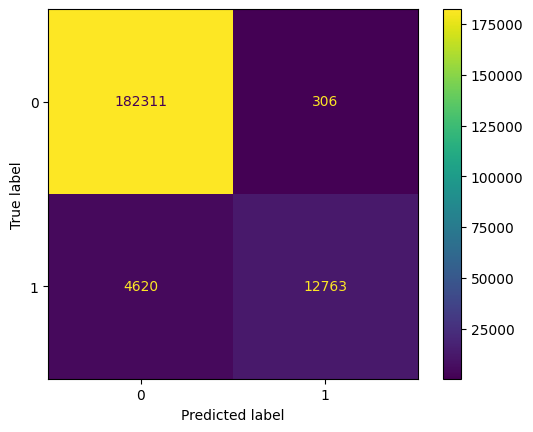

In [12]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_test_arr = y_test.squeeze()
correct = np.equal(y_pred, y_test_arr).sum().item()
acc = (correct / len(y_pred)) * 100
precision = precision_score(y_test_arr, np.round(y_pred))
recall = recall_score(y_test_arr, np.round(y_pred))

print(f"Eval Metrics: \n Accuracy: {acc:>0.1f}%, "
      f"Precision: {precision:.4f}, Recall: {recall:.4f} \n")

c_matrix = confusion_matrix(y_test_arr, y_pred)
ConfusionMatrixDisplay(c_matrix).plot()

## Example: Is Sally's transaction likely to be fraudulent?

Here is the order of the fields from Sally's transaction details:
* distance_from_last_transaction
* ratio_to_median_price
* used_chip 
* used_pin_number
* online_order 

In [13]:
sally_transaction_details = [
    [0.3111400080477545,
    1.9459399775518593,
    1.0,
    0.0,
    0.0]
    ]

prediction = sess.run([output_name], {input_name: scaler.transform(sally_transaction_details).astype(np.float32)})

print("Is Sally's transaction predicted to be fraudulent? (true = YES, false = NO) ")
print(np.squeeze(prediction) > threshold)

print("How likely was Sally's transaction to be fraudulent? ")
print("{:.5f}".format(100 * np.squeeze(prediction)) + "%")

Is Sally's transaction predicted to be fraudulent? (true = YES, false = NO) 
False
How likely was Sally's transaction to be fraudulent? 
0.10514%
